# NOAA Right Whales Basic Entry

## Imports, Constants and Settings

In [2]:
import os,sys
from shutil import copyfile
from PIL import Image
from keras.preprocessing import image
import pandas as pd

utils_path = os.path.abspath(os.path.join('./utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)
from utils import *

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
CURRENT_DIR = os.getcwd()
LESSON_HOME_DIR = CURRENT_DIR
DATA_HOME_DIR = CURRENT_DIR + '/data/noaa'
TEST_PATH = DATA_HOME_DIR + '/test/' 
RESULTS_PATH = DATA_HOME_DIR + '/results/'


PATH = DATA_HOME_DIR + '/'

TRAIN_PATH = PATH + 'train/'
VALIDATION_PATH = PATH + 'validation/'

In [4]:
#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

## Helper Functions

In [5]:
def setup_standard_dir_structure():
    %cd $DATA_HOME_DIR
    %mkdir validation
    %mkdir results
    # Moving all test images to a class directory of 'unknown', to more easily work with batches
    %mkdir -p test/unknown
    %mkdir -p sample/train
    %mkdir -p sample/test
    %mkdir -p sample/validation
    %mkdir -p sample/results

# TODO: Make directory-agnostic
def count_images_in_training_set():
    %cd $DATA_HOME_DIR/train
    path, dirs, files = os.walk('.').next()
    return len(files)

# TODO: Make directory-agnostic
# TODO: Factor out common stuff
def move_training_images_to_validation_set(percent):
    total_in_validation_set = int(total_images_in_training_set * (percent / 100.0))

    print('Moving {total} from training set to validation set.').format(total=str(total_in_validation_set))

    %cd $DATA_HOME_DIR/train
    all_training_jpegs = glob('*.jpg')
    shuffled_training_jpegs = np.random.permutation(all_training_jpegs)
    for i in range(total_in_validation_set):
        os.rename(shuffled_training_jpegs[i], DATA_HOME_DIR + '/validation/' + shuffled_training_jpegs[i])

# TODO: Make directory-agnostic
# TODO: Factor out common stuff
def copy_training_images_to_sample(percent):
    total_in_sample_training_set = int(total_images_in_training_set * (percent / 100.0))

    print('Copying {total} from training set to sample training set.').format(total=str(total_in_sample_training_set))

    all_training_jpegs = glob('*.jpg')
    shuffled_training_jpegs = np.random.permutation(all_training_jpegs)
    for i in range(total_in_sample_training_set):
        copyfile(shuffled_training_jpegs[i], DATA_HOME_DIR + '/sample/train/' + shuffled_training_jpegs[i])
        
# TODO: Make directory-agnostic
# TODO: Factor out common stuff
def copy_validation_images_to_sample(percent):
    %cd $DATA_HOME_DIR/validation
    total_in_sample_validation_set = int(total_images_in_training_set * (percent / 100.0))

    print('Copying {total} from validation set to sample validation set.').format(total=str(total_in_sample_validation_set))

    all_training_jpegs = glob('*.jpg')
    shuffled_training_jpegs = np.random.permutation(all_training_jpegs)
    for i in range(total_in_sample_validation_set):
         copyfile(shuffled_training_jpegs[i], DATA_HOME_DIR + '/sample/validation/' + shuffled_training_jpegs[i])
           
def split_into_one_directory_per_class(dirs, classes):
    for dir in dirs:
        %cd $dir
        for categoryClass in classes:
            %mkdir $categoryClass
            %mv {categoryClass}.*.jpg {categoryClass}/
            
def move_test_images_to_unknown_category_for_easier_batching():
    %cd $TEST_PATH
    %mv *.jpg unknown/

## Downloading Kaggle Data

Go ahead and run the following:

```
kg config -u farlion -p -c noaa-right-whale-recognition
```


In [ ]:
!kg download

Now we're placing them into the following structure

```
utils/
    vgg16.py
    utils.py
lesson1/
    redux.ipynb
    data/
        noaa/
            train/
                cat.437.jpg
                dog.9924.jpg
                cat.1029.jpg
                dog.4374.jpg
            test/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

In [ ]:
!unzip -q sample_submission.csv.zip
!unzip -q train.csv.zip
!unzip -q imgs.zip

In [ ]:
#!rm sample_submission.csv.zip imgs_subset.zip train.csv.zip w_7489.jpg.zip

In [ ]:
!mkdir -p data/noaa
!mv imgs data/noaa/

## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Create Training, Validation and Sample sets

In [ ]:
%mkdir $DATA_HOME_DIR/test/
%mv $DATA_HOME_DIR/imgs/* $DATA_HOME_DIR/test/

### Create Training Set from CSV

In [ ]:
# Read CSV
training_csv_file = LESSON_HOME_DIR + '/train.csv'
training_data_frame = pd.read_csv(training_csv_file)
training_data_frame.head(5)

In [ ]:
training_data_frame.describe()

In [ ]:
# Grab missing image
!unzip -q {LESSON_HOME_DIR}/w_7489.jpg.zip
!mv w_7489.jpg {TEST_PATH}

In [ ]:
%mkdir {DATA_HOME_DIR}/train/
training_set_path = DATA_HOME_DIR + '/train/'
training_set_images = training_data_frame['Image']
training_set_whaleIds = training_data_frame['whaleID']
for i in range(len(training_set_images)):
    filename_without_extension = os.path.splitext(training_set_images[i])[0]
    copyfile(TEST_PATH + training_set_images[i], training_set_path + training_set_whaleIds[i] + '.' + filename_without_extension + '.jpg')

### Do the rest

In [ ]:
setup_standard_dir_structure()

In [ ]:
total_images_in_training_set = count_images_in_training_set()
print('We have {total} images in total in our training set.').format(total=str(total_images_in_training_set))

In [ ]:
move_training_images_to_validation_set(percent=10)

In [ ]:
copy_training_images_to_sample(percent=1)

In [ ]:
copy_validation_images_to_sample(percent=0.25)

In [ ]:
move_test_images_to_unknown_category_for_easier_batching()

## Split up image files into class directories

In [ ]:
dirs = ['{}/sample/train'.format(DATA_HOME_DIR), 
        '{}/sample/validation'.format(DATA_HOME_DIR),
        '{}/validation'.format(DATA_HOME_DIR),
        '{}/train'.format(DATA_HOME_DIR)]
set_of_whaleIds = set(training_set_whaleIds)
split_into_one_directory_per_class(dirs=dirs, classes=set_of_whaleIds)

## Finetune and Train Model

In [37]:
%cd $DATA_HOME_DIR

vgg = Vgg16()

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/noaa-right-whale-recognition/data/noaa


In [38]:
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.01

In [ ]:
train_batches = vgg.get_batches(TRAIN_PATH, batch_size=BATCH_SIZE)
validation_batches = vgg.get_batches(VALIDATION_PATH, batch_size=BATCH_SIZE)

vgg.finetune(train_batches)

In [ ]:
#Not sure if we set this for all fits
vgg.model.optimizer.lr = LEARNING_RATE

In [ ]:
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(EPOCHS):
    print('Running epoch {}').format(epoch)
    vgg.fit(train_batches, validation_batches, nb_epoch=1)
    latest_weights_filename = 'ft{}.h5'.format(epoch)
    vgg.model.save_weights(RESULTS_PATH + latest_weights_filename)
print('Completed {} fit operations').format(EPOCHS)

## Generate Predictions

In [ ]:
vgg.model.load_weights(RESULTS_PATH + 'ft0.h5')

In [ ]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
prediction_batches, predictions = vgg.test(TEST_PATH, batch_size=BATCH_SIZE)

In [ ]:
prediction_filenames = prediction_batches.filenames

In [ ]:
prediction_batches.classes

In [ ]:
# You can verify the column ordering by viewing some images
Image.open(TEST_PATH + prediction_filenames[0])

In [ ]:
#Save our test results arrays so we can use them again later
save_array(RESULTS_PATH + 'predictions.dat', predictions)
save_array(RESULTS_PATH + 'prediction_filenames.dat', prediction_filenames)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [39]:
vgg.model.load_weights(RESULTS_PATH + 'ft0.h5')

In [40]:
validation_batches, validation_probabilities = vgg.test(VALIDATION_PATH, batch_size=BATCH_SIZE)
validation_filenames = validation_batches.filenames
expected_class_indices = validation_batches.classes

Found 454 images belonging to 447 classes.


In [9]:
validation_probabilities

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [10]:
expected_class_indices

array([  2,   2,   4,   6,   7,   9,   9,   9,  12,  12,  17,  18,  19,  19,  20,  21,  23,  23,
        25,  28,  28,  28,  29,  29,  30,  31,  31,  32,  32,  34,  35,  35,  35,  38,  39,  39,
        43,  43,  43,  44,  45,  45,  46,  46,  49,  49,  49,  49,  49,  50,  50,  50,  51,  52,
        53,  55,  55,  56,  56,  57,  57,  57,  58,  58,  59,  60,  60,  64,  65,  67,  69,  71,
        71,  72,  73,  73,  75,  79,  80,  80,  81,  81,  81,  82,  84,  84,  85,  86,  99, 105,
       106, 107, 107, 109, 109, 109, 109, 109, 110, 111, 111, 111, 112, 112, 112, 112, 112, 114,
       114, 114, 115, 115, 115, 117, 118, 119, 122, 126, 129, 129, 129, 132, 133, 133, 134, 135,
       135, 136, 136, 136, 136, 137, 138, 138, 139, 139, 140, 140, 140, 140, 141, 141, 142, 142,
       142, 143, 144, 145, 146, 146, 148, 149, 150, 150, 153, 153, 153, 153, 155, 155, 156, 156,
       157, 157, 157, 158, 158, 158, 159, 161, 161, 161, 162, 163, 165, 166, 166, 166, 166, 168,
       169, 172, 172, 172, 175

In [11]:
validation_probabilities.shape

(454, 447)

In [ ]:
# Playing around with NP
a = np.arange(12).reshape(3,4)
a

In [ ]:
np.argmax(a, axis=1)

In [ ]:
np.amax(a, axis=1)

In [13]:
# These should represent the predicted class index per image
predicted_class_indices = np.argmax(validation_probabilities, axis=1)

In [14]:
predicted_probabilities = np.amax(validation_probabilities, axis=1)

### These are our actual whales<->class mappings

In [41]:
class_index_mapping = validation_batches.class_indices
class_index_mapping

{'whale_00195': 0,
 'whale_00442': 1,
 'whale_02411': 2,
 'whale_02608': 3,
 'whale_02839': 4,
 'whale_03103': 5,
 'whale_03227': 6,
 'whale_03623': 7,
 'whale_03728': 8,
 'whale_03935': 9,
 'whale_03990': 10,
 'whale_04373': 11,
 'whale_04397': 12,
 'whale_04435': 13,
 'whale_04480': 14,
 'whale_04540': 15,
 'whale_05140': 16,
 'whale_05349': 17,
 'whale_05487': 18,
 'whale_05661': 19,
 'whale_05784': 20,
 'whale_06069': 21,
 'whale_06334': 22,
 'whale_06339': 23,
 'whale_06967': 24,
 'whale_06997': 25,
 'whale_07331': 26,
 'whale_07483': 27,
 'whale_07647': 28,
 'whale_07808': 29,
 'whale_07863': 30,
 'whale_08017': 31,
 'whale_08181': 32,
 'whale_08324': 33,
 'whale_08439': 34,
 'whale_08637': 35,
 'whale_08700': 36,
 'whale_08729': 37,
 'whale_08923': 38,
 'whale_09062': 39,
 'whale_09181': 40,
 'whale_09422': 41,
 'whale_09454': 42,
 'whale_09651': 43,
 'whale_09913': 44,
 'whale_10005': 45,
 'whale_10021': 46,
 'whale_10583': 47,
 'whale_10977': 48,
 'whale_11076': 49,
 'whale_11

In [16]:
#Helper function to plot images by index in the validation set 
#plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(VALIDATION_PATH + validation_filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 4 correct labels


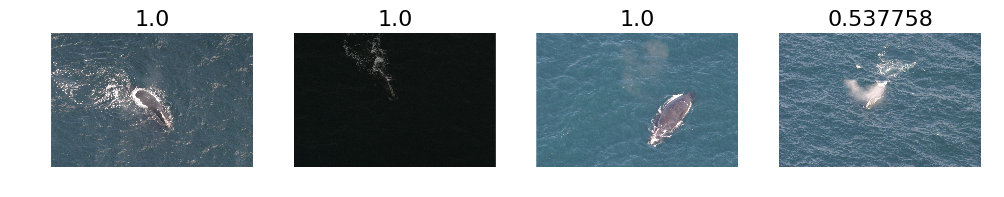

In [19]:
#1. A few correct labels at random
correct = np.where(predicted_class_indices==expected_class_indices)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, predicted_probabilities[idx])

Found 450 incorrect labels


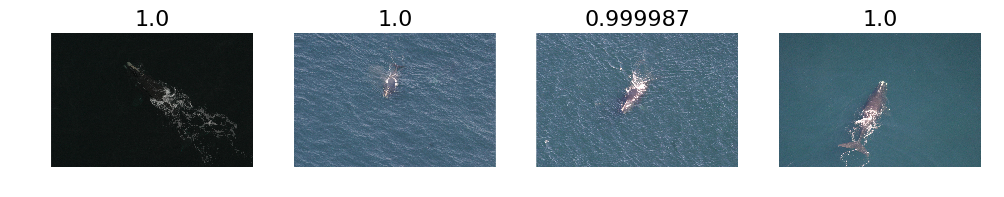

In [20]:
#2. A few incorrect labels at random
incorrect = np.where(predicted_class_indices!=expected_class_indices)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, predicted_probabilities[idx])

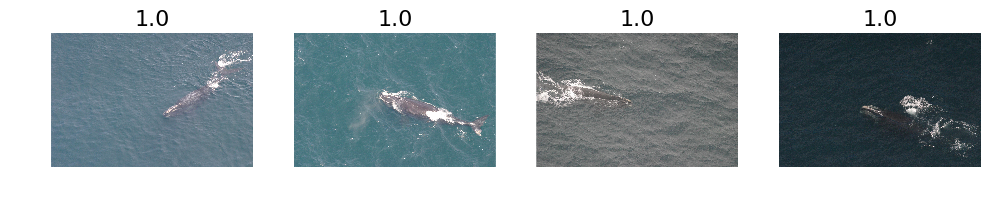

In [21]:
#3. The most certain labels (ie those with probability closest to 1).
most_certain = np.argsort(np.abs(predicted_probabilities-1))
plots_idx(most_certain[:n_view], predicted_probabilities[most_certain])

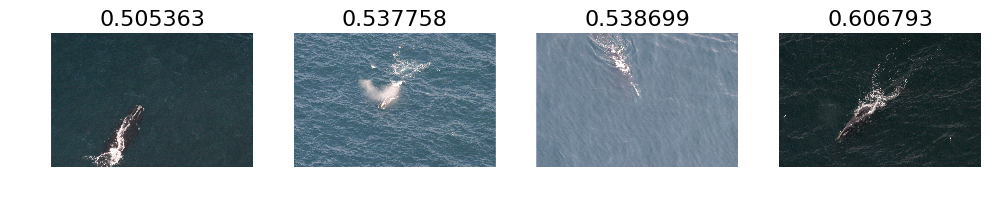

In [22]:
#4. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(predicted_probabilities-0.5))
plots_idx(most_uncertain[:n_view], predicted_probabilities[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_class_indices, predicted_class_indices)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


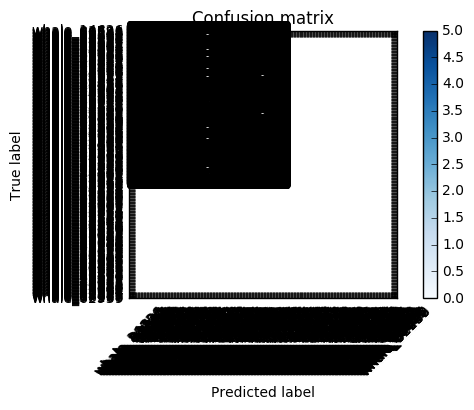

In [25]:
plot_confusion_matrix(cm, validation_batches.class_indices)

## Submit Predictions to Kaggle

Here's the format Kaggle requires for new submissions:
```
Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,whale_03935,whale_03990,whale_04373,whale_04397,whale_04435,whale_04480,whale_04540,whale_05140,whale_05349,whale_05487,whale_05661,whale_05784,whale_06069,whale_06334,whale_06339,whale_06967,whale_06997,whale_07331,whale_07483,whale_07647,whale_07808,whale_07863,whale_08017,whale_08181,whale_08324,whale_08439,whale_08637,whale_08700,whale_08729,whale_08923,whale_09062,whale_09181,whale_09422,whale_09454,whale_09651,whale_09913,whale_10005,whale_10021,whale_10583,whale_10977,whale_11076,whale_11099,whale_11242,whale_11555,whale_11625,whale_11708,whale_12074,whale_12085,whale_12609,whale_12661,whale_12820,whale_13288,whale_13701,whale_13789,whale_13863,whale_14094,whale_14270,whale_14626,whale_14892,whale_15078,whale_15079,whale_15434,whale_15519,whale_15615,whale_16406,whale_16576,whale_16738,whale_16762,whale_17327,whale_17528,whale_17601,whale_17604,whale_17785,whale_18158,whale_18845,whale_18989,whale_19027,whale_19041,whale_19906,whale_20248,whale_20448,whale_21160,whale_21213,whale_21655,whale_21873,whale_22059,whale_22101,whale_22118,whale_22212,whale_22297,whale_22448,whale_22848,whale_23118,whale_23367,whale_23467,whale_23525,whale_23574,whale_23821,whale_23847,whale_23855,whale_24458,whale_24679,whale_24730,whale_24815,whale_25659,whale_25715,whale_25878,whale_26212,whale_26288,whale_26397,whale_26654,whale_26686,whale_27085,whale_27221,whale_27820,whale_27834,whale_27860,whale_28216,whale_28263,whale_28384,whale_28892,whale_29172,whale_29294,whale_29569,whale_29858,whale_30074,whale_30331,whale_31594,whale_31739,whale_32021,whale_32087,whale_32198,whale_32702,whale_33140,whale_33152,whale_33195,whale_33723,whale_33961,whale_34488,whale_34513,whale_34656,whale_34663,whale_34798,whale_34813,whale_35004,whale_35426,whale_35430,whale_35594,whale_35844,whale_36154,whale_36231,whale_36300,whale_36437,whale_36648,whale_36851,whale_37014,whale_37154,whale_37269,whale_37301,whale_37654,whale_37658,whale_38008,whale_38191,whale_38288,whale_38302,whale_38437,whale_38543,whale_38681,whale_38817,whale_38894,whale_38906,whale_39293,whale_39674,whale_39689,whale_39915,whale_40169,whale_40190,whale_40483,whale_40885,whale_41125,whale_41776,whale_41805,whale_41881,whale_41921,whale_42191,whale_43045,whale_43326,whale_43374,whale_43961,whale_43971,whale_44071,whale_44127,whale_44699,whale_44747,whale_45062,whale_45294,whale_45367,whale_45465,whale_45728,whale_46169,whale_46747,whale_46974,whale_47062,whale_47700,whale_47734,whale_47768,whale_47858,whale_48024,whale_48386,whale_48415,whale_48490,whale_48497,whale_48633,whale_48813,whale_48966,whale_49135,whale_49210,whale_49237,whale_49277,whale_49491,whale_49530,whale_49832,whale_49877,whale_50021,whale_51114,whale_51195,whale_51332,whale_51538,whale_51603,whale_52100,whale_52342,whale_52505,whale_52749,whale_52759,whale_52998,whale_53079,whale_53580,whale_53889,whale_54497,whale_54574,whale_54796,whale_54850,whale_54920,whale_55079,whale_55333,whale_55550,whale_55861,whale_56281,whale_57251,whale_57338,whale_58010,whale_58309,whale_58362,whale_58474,whale_58747,whale_58972,whale_59173,whale_59255,whale_59627,whale_60451,whale_60729,whale_60921,whale_61260,whale_61461,whale_61728,whale_61924,whale_62655,whale_62939,whale_63541,whale_63816,whale_63948,whale_64006,whale_64274,whale_64299,whale_64496,whale_64526,whale_64634,whale_64714,whale_64903,whale_64937,whale_64989,whale_65057,whale_65263,whale_65586,whale_65737,whale_66205,whale_66353,whale_66421,whale_66539,whale_66711,whale_66852,whale_66935,whale_67036,whale_67407,whale_67611,whale_67614,whale_67685,whale_67801,whale_68116,whale_68338,whale_68774,whale_68789,whale_69084,whale_69459,whale_69619,whale_69943,whale_70138,whale_70904,whale_71062,whale_71554,whale_72235,whale_72327,whale_72820,whale_73080,whale_73136,whale_73167,whale_73592,whale_73666,whale_73684,whale_74062,whale_74162,whale_74232,whale_74439,whale_74625,whale_74683,whale_74828,whale_74935,whale_75215,whale_75413,whale_75455,whale_75682,whale_75767,whale_75932,whale_76398,whale_76782,whale_77693,whale_77984,whale_78280,whale_78372,whale_78395,whale_78565,whale_78628,whale_78785,whale_79166,whale_79193,whale_79199,whale_79439,whale_79648,whale_79823,whale_79948,whale_80124,whale_80247,whale_80405,whale_80947,whale_81136,whale_81768,whale_81818,whale_81875,whale_81915,whale_81960,whale_82064,whale_82089,whale_82387,whale_82548,whale_82554,whale_82602,whale_83157,whale_83791,whale_83892,whale_84178,whale_84264,whale_84963,whale_85464,whale_85670,whale_86041,whale_86081,whale_86158,whale_86206,whale_86377,whale_86527,whale_86585,whale_87155,whale_87291,whale_87420,whale_87604,whale_87622,whale_88085,whale_88147,whale_88226,whale_88432,whale_88478,whale_88547,whale_88746,whale_88756,whale_89211,whale_89271,whale_89456,whale_89541,whale_89615,whale_90141,whale_90244,whale_90271,whale_90377,whale_90446,whale_90820,whale_90911,whale_90929,whale_90957,whale_90966,whale_91826,whale_92153,whale_92465,whale_92515,whale_92686,whale_94176,whale_94546,whale_95091,whale_95370,whale_95831,whale_96240,whale_96385,whale_97440,whale_97542,whale_97688,whale_97882,whale_97924,whale_98151,whale_98507,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
w_1947.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

```

In [8]:
#Load our test predictions from file
predictions = load_array(RESULTS_PATH + 'predictions.dat')
prediction_filenames = load_array(RESULTS_PATH + 'prediction_filenames.dat')

In [16]:
stripped_filenames = np.array([os.path.basename(filename) for filename in prediction_filenames])

In [21]:
predictions.shape

(11469, 447)

In [22]:
rounded_predictions = predictions.round()
rounded_predictions

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [27]:
# Playing around to find out how to insert a column
a = np.arange(12).reshape(3,4)
print(a)
b = np.insert(a, 0, [15, 15, 15], axis=1)
print(b)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[15  0  1  2  3]
 [15  4  5  6  7]
 [15  8  9 10 11]]


In [33]:
rounded_predictions_as_strings = rounded_predictions.astype(int).astype('str')
submission_array = np.insert(rounded_predictions_as_strings, 0, stripped_filenames, axis=1)
submission_array[2:3]

array([['w_4494.jpg', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0'

In [60]:
# Compute correct header
import operator
class_index_mapping
sorted_whale_category_names = np.array(sorted(class_index_mapping.items(), key=operator.itemgetter(1)))[:,0]
submission_header = ','.join(np.insert(sorted_whale_category_names, 0, 'Image'))
submission_header

'Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,whale_03935,whale_03990,whale_04373,whale_04397,whale_04435,whale_04480,whale_04540,whale_05140,whale_05349,whale_05487,whale_05661,whale_05784,whale_06069,whale_06334,whale_06339,whale_06967,whale_06997,whale_07331,whale_07483,whale_07647,whale_07808,whale_07863,whale_08017,whale_08181,whale_08324,whale_08439,whale_08637,whale_08700,whale_08729,whale_08923,whale_09062,whale_09181,whale_09422,whale_09454,whale_09651,whale_09913,whale_10005,whale_10021,whale_10583,whale_10977,whale_11076,whale_11099,whale_11242,whale_11555,whale_11625,whale_11708,whale_12074,whale_12085,whale_12609,whale_12661,whale_12820,whale_13288,whale_13701,whale_13789,whale_13863,whale_14094,whale_14270,whale_14626,whale_14892,whale_15078,whale_15079,whale_15434,whale_15519,whale_15615,whale_16406,whale_16576,whale_16738,whale_16762,whale_17327,whale_17528,whale_17601,whale_17604,whale_17785,whale_181

In [69]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
formatter_string_use_pandas_for_this = '%s' + len(class_index_mapping) * ',%s'
np.savetxt(submission_file_name, submission_array, header=submission_header, fmt=formatter_string_use_pandas_for_this, comments='')

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/noaa-right-whale-recognition/data/noaa


In [70]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/noaa/'+submission_file_name)

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/noaa-right-whale-recognition


/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/noaa-right-whale-recognition/data/noaa/submission1.csv